## Quantitative Analysis: Bitcoin Price Prediction for Hourly-frequency Trading
7/2/2023
<br>Lidong (Aaron) Yang
<br>Jiadi Zhang

In this notebook, we import the feature-engineered data, and modeled on different machine learning methods. Next, we conducted cost-free backtests, which is a process of simulating trades on historic data to test the return.

The feature engineering process is not disclosed in this notebook, so do the hyperparameters for the LSTM model.

Disclaimer: This project is not finished, so there are some inconsistencies in the notebook.


# Notbook layout:

1. Importing feature engineered data
2. Modeling: each model predicts either the price or the price change of the next hour of bitcoin. Each model has at least two versions:
    1) Linear models:
    <br> lasso1: a lasso regression that predicts price with all available features
    <br> lasso2: a lsso regression that predicts price with only features that describe the previous prices of bitcoin.
    <br> ridge1: a ridge regression that predicts price with all available features 
    <br> ridge2: a ridge regression that predicts price with only features that describe the previous prices of bitcoin.
    <br> ridge3: a ridge regression that predcits price change of bitcoin with only features that describe the previous prices of bitcoin.
    2) Tree_based models:
    <br> random forest1: a random forest regression that predicts price with all available features 
    <br> random forest2: a random forest regression that predicts price with only features that describe the previous prices of bitcoin.
    <br> XGBoost1: a XGB regression that predicts price of bitcoin with all available features 
    <br> XGBoost2: a XGB regression that predicts price with features that describe the previous prices of bitcoin.
    3) Neural Network
    <br> Multi-layer perceptron1: a MLP neural net that predicts the price of bitcoin with all available features
    <br> Multi-layer perceptron2: a MLP neural net that predicts the price change of bitcoin with all available features
    <br> LSTM2: a LSTM neural net that has its exclusive feature engineering. This LSTM model accepts only time-series input.
5. Trading simulation on validation set.
6. Examining test set performances.
7. Trading simulation on the test sets.
      (1) Simulation with the best performing models
      (2) Simulation with the other models.

# Data Preparation

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas_ta as ta
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import RobustScaler,MinMaxScaler,PowerTransformer,StandardScaler
import sklearn.metrics as metrics
import seaborn as sns
from sklearn.model_selection import GridSearchCV  
from sklearn.pipeline import make_pipeline

### Importing feature-engineered data

In [2]:

# Create a list of the filenames to import
filenames = ['X_train_d.csv', 'X_valid_d.csv', 'X_test_d.csv', 'y_train_d.csv', 'y_valid_d.csv', 'y_test_d.csv']

# Create an empty dictionary to store the imported DataFrames
dataframes = {}

# Import each CSV file as a DataFrame and store it in the dictionary
for filename in filenames:
    name = filename.split('.')[0]  # Extract the object name from the filename
    df = pd.read_csv(filename)
    dataframes[name] = df

for name, df in dataframes.items():
    globals()[name] = df

In [3]:
filenames = ['X_train.npy', 'X_valid.npy', 'X_test.npy', 'y_train.npy', 'y_valid.npy', 'y_test.npy']

for filename in filenames:
    name = filename.split('.')[0]  # Extract the object name from the filename
    globals()[name] = np.load(filename)

In [4]:
unaccessible = [5, 6] + list(range(7, 19))
accessible = [i not in unaccessible for i in list(range(0,len(X_train_d.columns)))]

In [5]:
def r_squared(y_true, y_hat):
    y_true = np.array(y_true).flatten()
    y_mean = np.mean(y_true)
    ss_total = np.sum((y_true - y_mean)**2)
    ss_residual = np.sum((y_true - y_hat)**2)
    r2 = 1 - (ss_residual / ss_total)
    return r2

In [6]:
def calculate_metrics(y, ypred):
    y = np.array(y).flatten()
    MAE = metrics.mean_absolute_error(y, ypred)
    RMSE = metrics.mean_squared_error(y, ypred,squared=False)
    r2 =  r_squared(ypred,y)
    first_string = 'The MAE is '+str(MAE) + '. '
    second_string = '\nThe RMSE is '+str(RMSE) + '. '
    third_string = '\nThe r_squared is '+str(r2) + '.'
    print(first_string, second_string, third_string)

## Lasso 1 - using all features

In [7]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=0.1)
lasso.fit(X_train, y_train)

C:\Users\jiadiz\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.508e+09, tolerance: 1.923e+09
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

In [8]:
lasso_val_pred = lasso.predict(X_valid)

In [9]:
calculate_metrics(y_valid,lasso_val_pred )

The MAE is 309.3710953709695.  
The RMSE is 419.3315758809216.  
The r_squared is 0.9980029654975155.


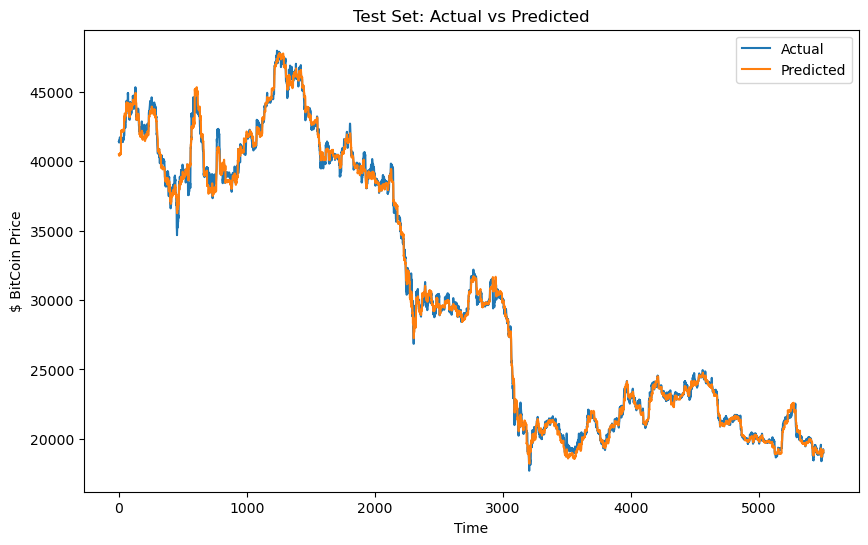

In [10]:

plt.figure(figsize=(10,6))
plt.plot(y_valid_d.index, y_valid, label='Actual')
plt.plot(y_valid_d.index, lasso_val_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()


## Lasso 2 - using only price features

In [11]:
from sklearn.linear_model import Lasso
lasso2 = Lasso(alpha=0.1)
lasso2.fit(X_train[:,accessible], y_train)

C:\Users\jiadiz\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.079e+09, tolerance: 1.923e+09
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=0.1)

In [12]:
lasso2_val_pred = lasso2.predict(X_valid[:,accessible])
calculate_metrics(y_valid,lasso2_val_pred)

The MAE is 289.11257762356485.  
The RMSE is 391.29621750022045.  
The r_squared is 0.9982686791510843.


## Ridge 1 - using all features

This model uses all available features

In [13]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1)

ridge.fit(X_train, y_train)


ridge_val_pred = ridge.predict(X_valid)


In [14]:
ridge_train_pred = ridge.predict(X_train)
calculate_metrics(y_train, ridge_train_pred)

The MAE is 38.890994540560435.  
The RMSE is 125.03658744755623.  
The r_squared is 0.9999194517158492.


The MAE is 132.07324052088418.  
The RMSE is 200.45250341400416.  
The r_squared is 0.9995430045316717.


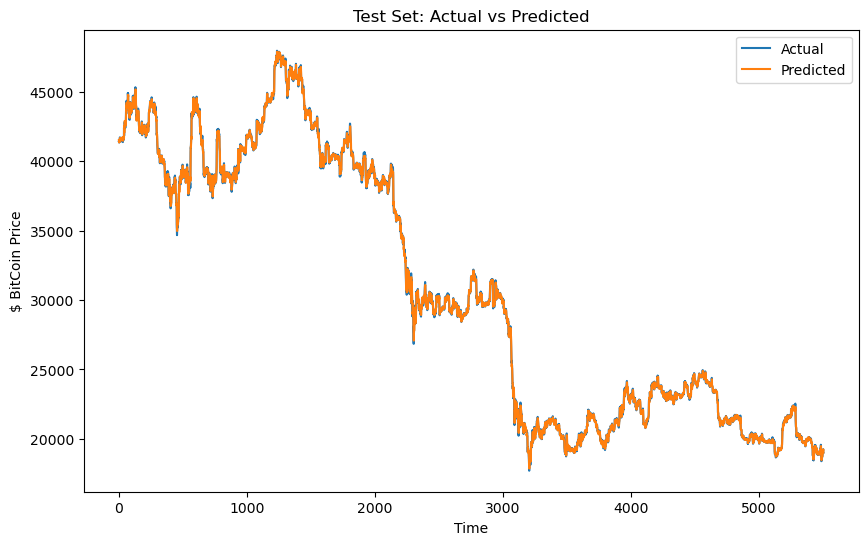

In [15]:
calculate_metrics(y_valid, ridge_val_pred)

plt.figure(figsize=(10,6))
plt.plot(y_valid_d.index, y_valid, label='Actual')
plt.plot(y_valid_d.index, ridge_val_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()


## Ridge 2 - using only price features.

In [16]:
from sklearn.linear_model import Ridge
ridge2 = Ridge(alpha=1)

ridge2.fit(X_train[:,accessible], y_train)

ridge2_val_pred = ridge2.predict(X_valid[:,accessible])

The MAE is 132.15999671924877.  
The RMSE is 200.50176844623928.  
The r_squared is 0.9995428713824807.


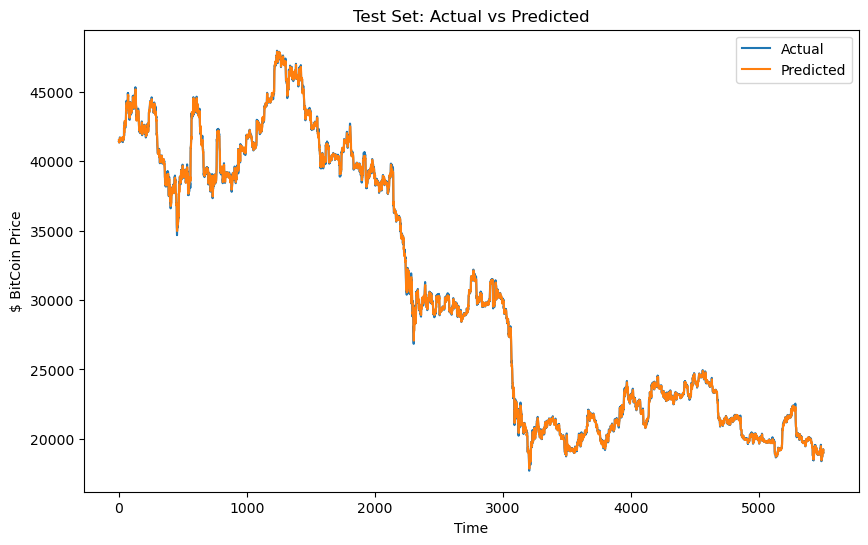

In [17]:
calculate_metrics(y_valid, ridge2_val_pred)

plt.figure(figsize=(10,6))
plt.plot(y_valid_d.index, y_valid, label='Actual')
plt.plot(y_valid_d.index, ridge2_val_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()

## Ridge 3: using only price features to predict price change

In [19]:
y_train_c = np.array([y_train[i] - y_train[i-1] for i in range(1,len(y_train))])
y_valid_c = np.array([y_valid[i] - y_valid[i-1] for i in range(1,len(y_valid))])
y_test_c = np.array([y_test[i] - y_test[i-1] for i in range(1,len(y_test))])       

In [20]:

ridge3 = Ridge(alpha=1)

ridge3.fit(X_train[1:,accessible],  y_train_c)


ridge3_val_pred = ridge3.predict(X_valid[1:,accessible])

calculate_metrics(ridge3_val_pred, y_valid_c)


The MAE is 130.44162207809518.  
The RMSE is 199.1729778395267.  
The r_squared is 0.07582113689753334.


We also transform the predicted price change into prices. 

In [21]:
ridge3_val_pred = ridge3_val_pred + y_valid[:len(y_valid)-1]

In [22]:
calculate_metrics(ridge3_val_pred,y_valid[1:])

The MAE is 130.44162207809518.  
The RMSE is 199.1729778395267.  
The r_squared is 0.9995489233089528.


# Tree-based models

## Random Forest 1 - using all features

random searching for the best hyperparameter:


The random search process is too long, thus it is commented out. The hyperparameters are put directly into the models.

In [23]:
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
#     'learning_rate': [0.01, 0.05 ,0.1, 0.2, 0.3 ,0.5],
#     'max_depth': [3, 5, 7, 9],
#     'min_child_weight': [1, 2, 3, 4,5],
#     'gamma': [0.0, 0.05, 0.1,0.15, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'reg_alpha': [0.0, 0.1, 0.2, 0.5],
#     'reg_lambda': [0.0, 0.1, 0.2, 0.5]
# }

# # Create an XGBoost regressor object
# xgb = XGBRegressor()

# # Split your data into training and testing sets

# # Perform random search
# random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=10, cv=3, random_state=42)
# random_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best Parameters:", rf_random_search.best_params_)
# print("Best Score:", rf_random_search.best_score_)
# final_xgb = rf_random_search.best_estimator_)

In [24]:
rf = RandomForestRegressor(n_estimators=200,n_jobs=-1,max_depth = 15,bootstrap=True,
                           verbose=5,random_state=123)
rf.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    8.6s


building tree 12 of 200
building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.1min


building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building t

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.6min


building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  3.5min finished


RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1,
                      random_state=123, verbose=5)

In [25]:
rf_val_pred = rf.predict(X_valid)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [26]:
calculate_metrics(y_valid, rf_val_pred)

The MAE is 513.5348508632947.  
The RMSE is 690.6167308239767.  
The r_squared is 0.9940280869882666.


We can see that the model degrades quickly since the model starts to fail capturing the price after may 2022. 

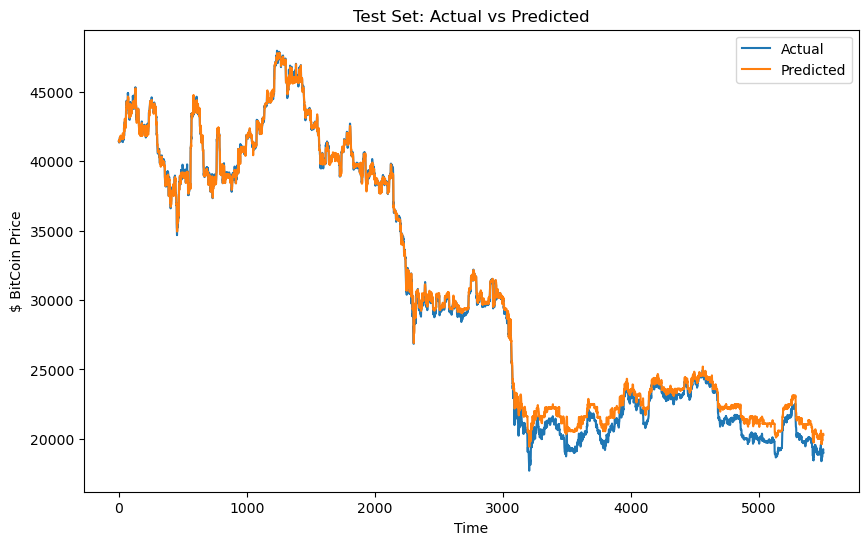

In [27]:

plt.figure(figsize=(10,6))
plt.plot(y_valid_d.index, y_valid, label='Actual')
plt.plot(y_valid_d.index, rf_val_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()


## Random Forest 2 - using only price features

In [28]:
rf2 = RandomForestRegressor(n_estimators=200,n_jobs=-1,max_depth = 15,bootstrap=True,
                           verbose=5,random_state=123)
rf2.fit(X_train[:,accessible],y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 1 of 200
building tree 2 of 200
building tree 3 of 200
building tree 4 of 200
building tree 5 of 200
building tree 6 of 200
building tree 7 of 200
building tree 8 of 200
building tree 9 of 200
building tree 10 of 200
building tree 11 of 200
building tree 12 of 200


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.2s


building tree 13 of 200
building tree 14 of 200
building tree 15 of 200
building tree 16 of 200
building tree 17 of 200
building tree 18 of 200
building tree 19 of 200
building tree 20 of 200
building tree 21 of 200
building tree 22 of 200
building tree 23 of 200
building tree 24 of 200
building tree 25 of 200
building tree 26 of 200
building tree 27 of 200
building tree 28 of 200
building tree 29 of 200
building tree 30 of 200
building tree 31 of 200
building tree 32 of 200
building tree 33 of 200
building tree 34 of 200
building tree 35 of 200
building tree 36 of 200
building tree 37 of 200
building tree 38 of 200
building tree 39 of 200
building tree 40 of 200
building tree 41 of 200
building tree 42 of 200
building tree 43 of 200
building tree 44 of 200
building tree 45 of 200
building tree 46 of 200
building tree 47 of 200
building tree 48 of 200
building tree 49 of 200
building tree 50 of 200
building tree 51 of 200
building tree 52 of 200
building tree 53 of 200
building tree 54

[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:   45.4s


building tree 65 of 200
building tree 66 of 200
building tree 67 of 200
building tree 68 of 200
building tree 69 of 200
building tree 70 of 200
building tree 71 of 200
building tree 72 of 200
building tree 73 of 200
building tree 74 of 200
building tree 75 of 200
building tree 76 of 200
building tree 77 of 200
building tree 78 of 200
building tree 79 of 200
building tree 80 of 200
building tree 81 of 200
building tree 82 of 200
building tree 83 of 200
building tree 84 of 200
building tree 85 of 200
building tree 86 of 200
building tree 87 of 200
building tree 88 of 200
building tree 89 of 200
building tree 90 of 200
building tree 91 of 200
building tree 92 of 200
building tree 93 of 200
building tree 94 of 200
building tree 95 of 200
building tree 96 of 200
building tree 97 of 200
building tree 98 of 200
building tree 99 of 200
building tree 100 of 200
building tree 101 of 200
building tree 102 of 200
building tree 103 of 200
building tree 104 of 200
building tree 105 of 200
building t

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  2.0min


building tree 155 of 200
building tree 156 of 200
building tree 157 of 200
building tree 158 of 200
building tree 159 of 200
building tree 160 of 200
building tree 161 of 200
building tree 162 of 200
building tree 163 of 200
building tree 164 of 200
building tree 165 of 200
building tree 166 of 200
building tree 167 of 200
building tree 168 of 200
building tree 169 of 200
building tree 170 of 200
building tree 171 of 200
building tree 172 of 200
building tree 173 of 200
building tree 174 of 200
building tree 175 of 200
building tree 176 of 200
building tree 177 of 200
building tree 178 of 200
building tree 179 of 200
building tree 180 of 200
building tree 181 of 200
building tree 182 of 200
building tree 183 of 200
building tree 184 of 200
building tree 185 of 200
building tree 186 of 200
building tree 187 of 200
building tree 188 of 200
building tree 189 of 200
building tree 190 of 200
building tree 191 of 200
building tree 192 of 200
building tree 193 of 200
building tree 194 of 200


[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.7min finished


RandomForestRegressor(max_depth=15, n_estimators=200, n_jobs=-1,
                      random_state=123, verbose=5)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


The MAE is 491.62919286167624.  
The RMSE is 662.6836312922645.  
The r_squared is 0.994536658115031.


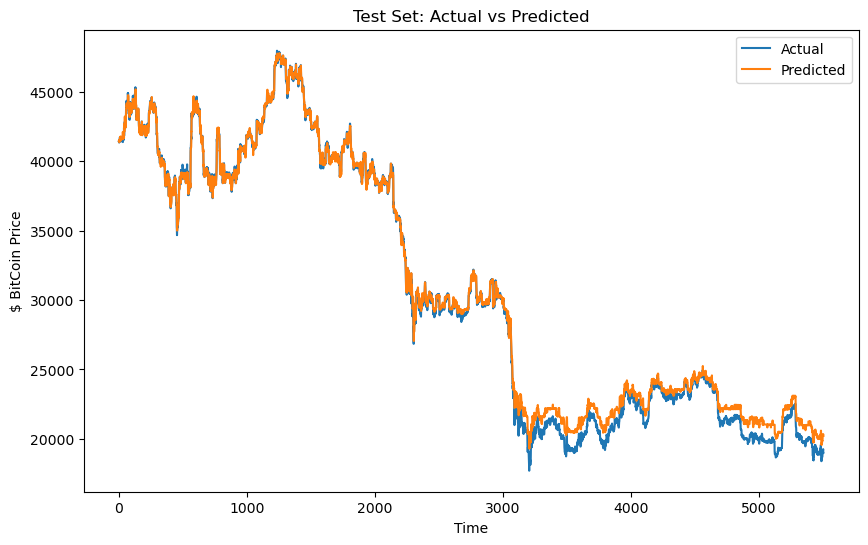

In [29]:

rf2_val_pred = rf2.predict(X_valid[:,accessible])
calculate_metrics(y_valid, rf2_val_pred)

plt.figure(figsize=(10,6))
plt.plot(y_valid_d.index, y_valid, label='Actual')
plt.plot(y_valid_d.index, rf2_val_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()


In [30]:
len('* Research Development and Reporting: Performed research on operations efficiency, product performance, and business intelligence. Communicated results to senior managements thru meetings, reports, and dashboards.*	Evaluate New Market Entry Potential: Conducted clustering, time-series forecasting, and regression analyses to predict the best geographies for the company to pursue expansion.* Threat Detection: Developed an index to rank competitors’ impacts on company revenue. Uncovering previously unknown market threats and aided the company in pivoting its marketing and sales strategy to avoid unnecessary competition.*	Web-development: Boosted lead-transfer rate by 30% by validating web-renewals through A/B tests .*	Data Management: Extracted & wrangled millions of internal/external datapoints into analyzable datasets for all projects thru R.  ')

855

It looks OK but a little bit off from 2022-11 to 2022-12, let's see if there is a way to tune the model.

## XGB - using all features

The random search process is too long, thus it is commented out. The hyperparameters are put directly into the models.

In [31]:
from xgboost import XGBRegressor

In [32]:
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800],
#     'learning_rate': [0.01, 0.05 ,0.1, 0.2, 0.3 ,0.5],
#     'max_depth': [3, 5, 7, 9],
#     'min_child_weight': [1, 2, 3, 4,5],
#     'gamma': [0.0, 0.05, 0.1,0.15, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'reg_alpha': [0.0, 0.1, 0.2, 0.5],
#     'reg_lambda': [0.0, 0.1, 0.2, 0.5]
# }

# # Create an XGBoost regressor object
# xgb = XGBRegressor()

# # Split your data into training and testing sets

# # Perform random search
# random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_grid, n_iter=10, cv=3, random_state=42)
# random_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best Parameters:", rf_random_search.best_params_)
# print("Best Score:", rf_random_search.best_score_)
# final_xgb = rf_random_search.best_estimator_)

In [33]:
# rf = RandomForestRegressor(n_estimators=100,n_jobs=-1,bootstrap=True,
#                            verbose=5,random_state=123)

# param_grid = {
#     'n_estimators': [100, 200, 300, 400],
#     'max_depth': [3, 5, 7, None],
#     'min_samples_split': [2, 4, 6,8 , 10],
#     'min_samples_leaf': [1, 2, 3, 4],
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'bootstrap': [True, False]
# }

# # Create a Random Forest regressor object
# rf = RandomForestRegressor()



# # Perform random search
# rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=3, random_state=42)
# rf_random_search.fit(X_train, y_train)

# # Print the best parameters and best score
# print("Best Parameters:", rf_random_search.best_params_)
# print("Best Score:", rf_random_search.best_score_)
# final_rf = random_search.best_estimator_

In [34]:
# It takes too long, I will comment them first
# grid_search.fit(X_train, y_train) 
# grid_search.best_params_ 
# # {'n_estimators': 500}

In [35]:
xgb=XGBRegressor(subsample = 0.6, reg_lambda= 0.2, n_estimators = 250, min_child_weight= 3, max_depth = 8, learning_rate = 0.03, gamma = 0.05, colsample_bytree = 1.0)

In [36]:
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.05, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=250, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [37]:
xgb_val_pred = xgb.predict(X_valid)

In [38]:
calculate_metrics(y_valid,xgb_val_pred
)


The MAE is 397.6198013180938.  
The RMSE is 531.2587647710704.  
The r_squared is 0.9965539667521938.


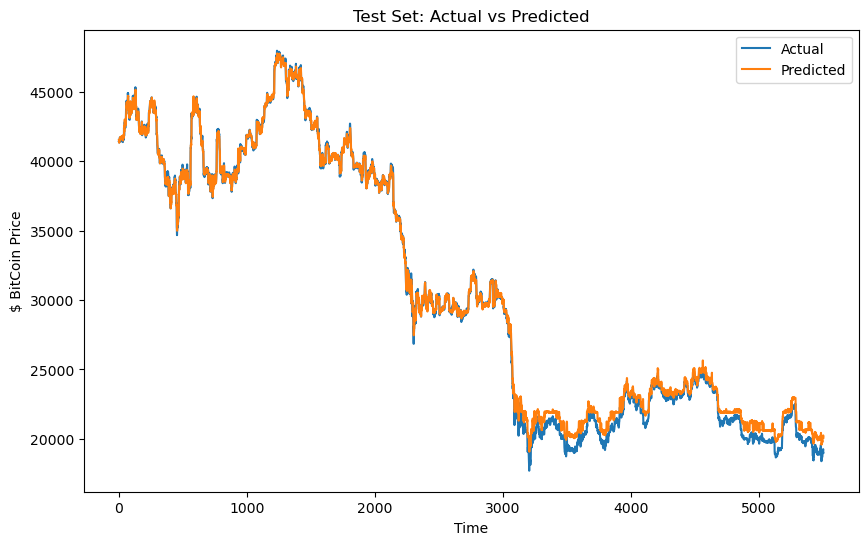

In [39]:
plt.figure(figsize=(10,6))
plt.plot(y_valid_d.index, y_valid, label='Actual')
plt.plot(y_valid_d.index, xgb_val_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()


## XGB 2 - using only price features

In [40]:
xgb2=XGBRegressor(subsample = 0.6, reg_lambda= 0.2, n_estimators = 250, min_child_weight= 3, max_depth = 8, learning_rate = 0.03, gamma = 0.05, colsample_bytree = 1.0)
xgb2.fit(X_train[:,accessible], y_train)
xgb2_val_pred = xgb2.predict(X_valid[:,accessible])

In [41]:
calculate_metrics(y_valid,xgb2_val_pred
)


The MAE is 385.84046596021165.  
The RMSE is 514.689235172919.  
The r_squared is 0.9967734282690289.


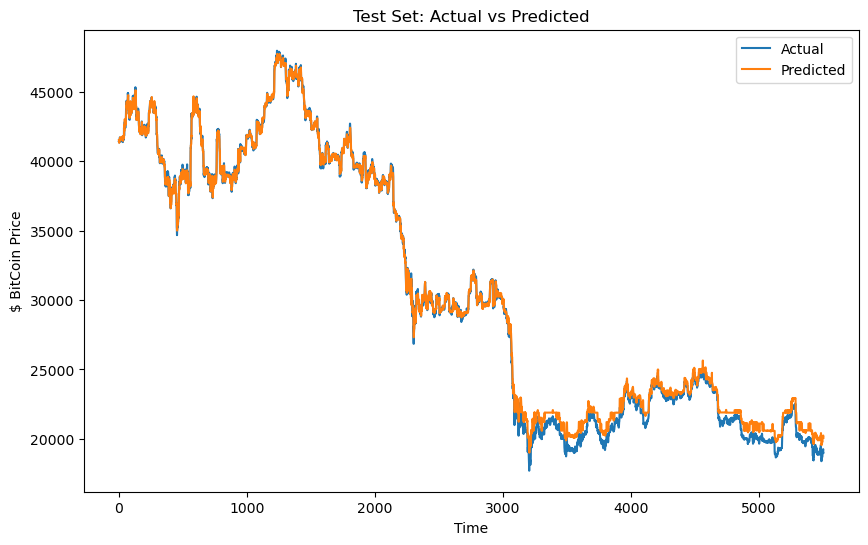

In [42]:
plt.figure(figsize=(10,6))
plt.plot(y_valid_d.index, y_valid, label='Actual')
plt.plot(y_valid_d.index, xgb2_val_pred , label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()

# Neural net 

## MLP 1 - using all features

In [43]:
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from scipy.stats import randint

In [44]:
X_train

array([[-1.73163126, -0.52582105, -0.52624364, ...,  0.4064188 ,
         0.86904088, -0.20254404],
       [-1.73163126, -0.52582105, -0.52624364, ...,  0.4064188 ,
         0.86904088, -0.20254404],
       [-1.73163126, -0.52582105, -0.52624364, ...,  0.4064188 ,
         0.86904088, -0.20254404],
       ...,
       [ 1.73222559,  2.14226142,  2.45298631, ...,  0.41254483,
        -0.35553804, -0.48738269],
       [ 1.73222559,  2.14226142,  2.45298631, ...,  0.41254483,
        -0.35553804, -0.48738269],
       [ 1.73222559,  2.14226142,  2.45298631, ...,  0.41254483,
        -0.35553804, -0.48738269]])

code for hyper parameter tuning (commented out to save time):

In [45]:
mlp = MLPRegressor(hidden_layer_sizes=[128,128, 128], activation = 'relu', learning_rate = 'adaptive', alpha = 0.01, max_iter = 150, random_state=42)
mlp.fit(X_train, y_train)

MLPRegressor(alpha=0.01, hidden_layer_sizes=[128, 128, 128],
             learning_rate='adaptive', max_iter=150, random_state=42)

In [46]:
mlp_val_pred = mlp.predict(X_valid)

In [47]:
calculate_metrics(y_valid, mlp_val_pred)

The MAE is 850.706232949446.  
The RMSE is 977.0714007759074.  
The r_squared is 0.9880227475357424.


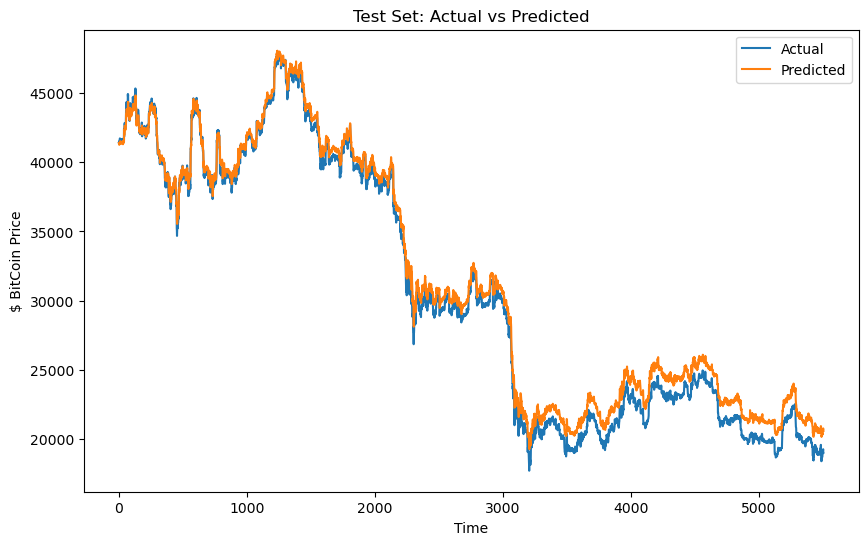

In [48]:
plt.figure(figsize=(10,6))
plt.plot(y_valid_d.index, y_valid, label='Actual')
plt.plot(y_valid_d.index, mlp_val_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()


## MLP 2 - using only price features to predict price change 

In [50]:
mlp2 = MLPRegressor(hidden_layer_sizes=[100,100,100,100,100], activation = 'relu', learning_rate = 'adaptive', alpha = 0.001, max_iter = 150, random_state=42)

mlp2.fit(X_train[1:,accessible], y_train_c)


mlp2_val_pred1 = mlp2.predict(X_valid[1:,accessible])

In [51]:
mlp2_val_pred2 = mlp2_val_pred1 + y_valid[:len(y_valid)-1]
calculate_metrics(y_valid[1:], mlp2_val_pred2)

The MAE is 134.93816828675415.  
The RMSE is 205.1236228102197.  
The r_squared is 0.9995205220417064.


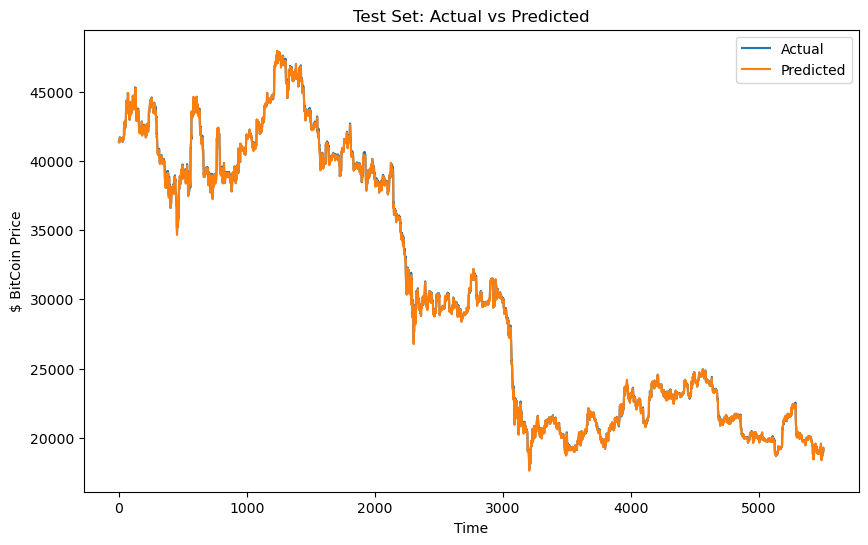

In [53]:
plt.figure(figsize=(10,6))
plt.plot(y_valid_d[:len(y_valid)-1].index, y_valid[:len(y_valid)-1], label='Actual')
plt.plot(y_valid_d[:len(y_valid)-1].index, mlp2_val_pred2 , label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()

### Importing feauture-engineered data for LSTM

In [54]:

filenames = ['X2_train_d.csv', 'X2_valid_d.csv', 'X2_test_d.csv', 'y2_train_d.csv', 'y2_valid_d.csv', 'y2_test_d.csv']


dataframes = {}


for filename in filenames:
    name = filename.split('.')[0]  
    df = pd.read_csv(filename)
    dataframes[name] = df

for name, df in dataframes.items():
    globals()[name] = df

In [55]:
filenames = ['X2_train_reshaped.npy', 'X2_valid_reshaped.npy', 'X2_test_reshaped.npy', 'y2_train_reshaped.npy', 'y2_valid_reshaped.npy', 'y2_test_reshaped.npy']

for filename in filenames:
    name = filename.split('.')[0]  # Extract the object name from the filename
    globals()[name] = np.load(filename)

## LSTM 2 - using a new set of price features

In [56]:
import pickle

# Load the pickle file
with open('lstm_hyperparameters.pickle', 'rb') as file:
    lstm_hyperparameters = pickle.load(file)


In [57]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras import regularizers
from keras.optimizers import Adam

input_dim = X2_train_reshaped.shape[2]
hidden_layers = lstm_hyperparameters['hidden_layers']
epoch = lstm_hyperparameters['epoch']
neurons = lstm_hyperparameters['neurons']
sequence_length = lstm_hyperparameters['sequence_length']

model2 = Sequential()
model2.add(LSTM(neurons, activation = 'relu', kernel_regularizer=regularizers.l2(0.3), input_shape=(sequence_length, input_dim), return_sequences=True))  # Adjust the number of units (128) as per your requirements

for i in range(hidden_layers):
    model2.add(LSTM(neurons, activation = 'relu' ,return_sequences=True))
              
model2.add(LSTM(neurons, activation ='relu'))
model2.add(Dense(1))  


model2.compile(optimizer='adam', loss='mean_squared_error') 

In [58]:
model2.load_weights('lstm_model3.h5')

In [59]:
model2.fit(X2_train_reshaped, y2_train_reshaped, epochs=5, batch_size=32)  

Epoch 1/5
3095/3095 [==============================] - 77s 23ms/step - loss: 26035.0527
Epoch 2/5
3095/3095 [==============================] - 72s 23ms/step - loss: 21806.7285
Epoch 3/5
3095/3095 [==============================] - 72s 23ms/step - loss: 20107.4160
Epoch 4/5
3095/3095 [==============================] - 72s 23ms/step - loss: 18971.4375
Epoch 5/5
3095/3095 [==============================] - 72s 23ms/step - loss: 15117.2090


In [60]:
predictions = model2.predict(X2_valid_reshaped)

172/172 [==============================] - 2s 8ms/step


In [61]:
lstm2_val_pred = predictions.squeeze(1)
calculate_metrics(lstm2_val_pred, y2_valid_reshaped)

The MAE is 144.30116885569188.  
The RMSE is 169.92384823725487.  
The r_squared is 0.9996719241221568.


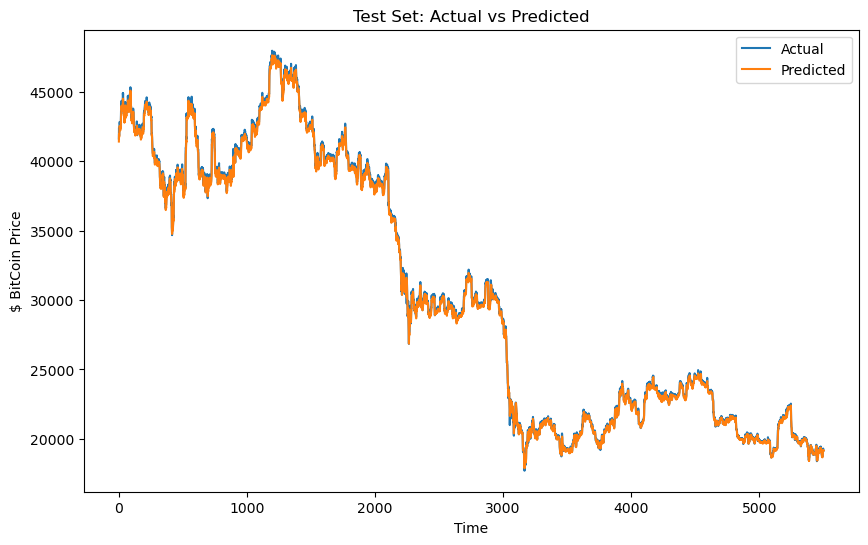

In [62]:
plt.figure(figsize=(10,6))
plt.plot(y2_valid_d.index[sequence_length-1:], y2_valid_reshaped, label='Actual')
plt.plot(y2_valid_d.index[sequence_length-1:], lstm2_val_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()

# Back test with the validation sets from the 3 models

In [64]:
val_outputs = (ridge_val_pred, ridge2_val_pred, ridge3_val_pred, lasso_val_pred, lasso2_val_pred, rf_val_pred, rf2_val_pred, xgb_val_pred, xgb2_val_pred, mlp_val_pred, mlp2_val_pred2)

column_names =['ridge_val_pred', 'ridge2_val_pred', 'ridge3_val_pred', 'lasso_val_pred', 'lasso2_val_pred', 'rf_val_pred', 'rf2_val_pred', 'xgb_val_pred', 'xgb2_val_pred', 'mlp_val_pred', 'mlp2_val_pred']

min_length = min([len(output) for output in val_outputs])

val_df = pd.DataFrame({'real_price': y_valid})

starting_position = len(val_df) - min_length

val_df = val_df.iloc[starting_position:,]

In [65]:
for output, column_name in zip(val_outputs,column_names):
    starting_position = len(output) - min_length
    print(column_name)
    val_df[column_name] = output[starting_position:] 
val_df['average_predicted_price'] = val_df.iloc[:,1:].mean(axis=1)

ridge_val_pred
ridge2_val_pred
ridge3_val_pred
lasso_val_pred
lasso2_val_pred
rf_val_pred
rf2_val_pred
xgb_val_pred
xgb2_val_pred
mlp_val_pred
mlp2_val_pred


In [66]:
val_df = val_df.reset_index(drop = True)

In [67]:
lstm_df = pd.DataFrame({'real_price':y2_valid_reshaped,'lstm2_val_pred':lstm2_val_pred}).reset_index(drop = True)

In [68]:
def back_test(df):
    for colname in df.columns[0:]:
        money = 50000
        coins = 2 
        for i in range(len(df)-1):

            if df[colname][i+1] > df['real_price'][i]:
                coins += money/df['real_price'][i] 
                money = 0
                
            elif df[colname][i+1] < df['real_price'][i]:
                money += coins * df['real_price'][i]
                coins = 0
        final_asset_level = max(money, coins*df['real_price'][len(df)-1])
        initial_asset_level = 50000 + 2*df['real_price'][0]
        asset_growth = (final_asset_level - initial_asset_level) /  initial_asset_level
        print( 'The asset growth rate would be ' + str( round(asset_growth*100,2)) + '% if trades were conducted upon ' +str(colname) + ' in a ' + str(round(len(df)/24,2)) + 'days period')

In [69]:
back_test(val_df)

The asset growth rate would be 11738714.11% if trades were conducted upon real_price in a 229.29days period
The asset growth rate would be 4688.31% if trades were conducted upon ridge_val_pred in a 229.29days period
The asset growth rate would be 4724.64% if trades were conducted upon ridge2_val_pred in a 229.29days period
The asset growth rate would be 5261.97% if trades were conducted upon ridge3_val_pred in a 229.29days period
The asset growth rate would be 324.94% if trades were conducted upon lasso_val_pred in a 229.29days period
The asset growth rate would be 274.31% if trades were conducted upon lasso2_val_pred in a 229.29days period
The asset growth rate would be 74.88% if trades were conducted upon rf_val_pred in a 229.29days period
The asset growth rate would be 73.72% if trades were conducted upon rf2_val_pred in a 229.29days period
The asset growth rate would be 189.99% if trades were conducted upon xgb_val_pred in a 229.29days period
The asset growth rate would be 148.45% 

In [70]:
back_test(lstm_df)

The asset growth rate would be 12069325.23% if trades were conducted upon real_price in a 229.17days period
The asset growth rate would be 75860.49% if trades were conducted upon lstm2_val_pred in a 229.17days period


As shown in the simulation conducted upon the validation set, ridge, and LSTM have shown superior result. 
Now we will conduct the final test on the test set to test the robustness of all the models, which could root out all the models that are overfitted or would show signs of degradation. 

# Final Test

Ridge

In [71]:
ridge_test_pred = ridge.predict(X_test)
calculate_metrics(y_test,ridge_test_pred)

The MAE is 64.98348680886056.  
The RMSE is 110.98786433172327.  
The r_squared is 0.9993646456905821.


In [72]:
ridge2_test_pred = ridge2.predict(X_test[:,accessible])
calculate_metrics(ridge2_test_pred, y_test)

The MAE is 65.08717814557909.  
The RMSE is 110.97944387154071.  
The r_squared is 0.9993645611849641.


In [73]:
pred_change = ridge3.predict(X_test[1:,accessible])
ridge3_test_pred = pred_change + y_test[0:len(y_test)-1]
calculate_metrics(ridge3_test_pred, y_test[1:])

The MAE is 64.02046003022532.  
The RMSE is 110.4518112559874.  
The r_squared is 0.9993706568570188.


# LSTM

In [80]:
predictions = model2.predict(X2_test_reshaped)
lstm_test_pred = predictions.squeeze(1)
calculate_metrics(lstm_test_pred, y2_test_reshaped)

172/172 [==============================] - 1s 9ms/step
The MAE is 82.52813535701172.  
The RMSE is 103.08689852086331.  
The r_squared is 0.9994564678596968.


In [81]:
predictions = model2.predict(X2_test_reshaped)
lstm2_test_pred = predictions.squeeze(1)
calculate_metrics(lstm2_test_pred, y2_test_reshaped)

172/172 [==============================] - 2s 9ms/step
The MAE is 82.52813535701172.  
The RMSE is 103.08689852086331.  
The r_squared is 0.9994564678596968.


In [85]:
test_outputs = (ridge_test_pred, ridge2_test_pred, ridge3_test_pred,lstm_test_pred)
column_names =['ridge_test_pred', 'ridge2_test_pred', 'ridge3_test_pred','lstm_test_pred']

min_length = min([len(output) for output in test_outputs])

test_df = pd.DataFrame({'real_price': y_test})

starting_position = len(test_df) - min_length

test_df = test_df.iloc[starting_position:,]

for output, column_name in zip(test_outputs,column_names):
    starting_position = len(output) - min_length
    print(column_name)
    test_df[column_name] = output[starting_position:] 
test_df['average_predicted_price'] = test_df.iloc[:,1:].mean(axis=1)
test_df = test_df.reset_index(drop = True)

ridge_test_pred
ridge2_test_pred
ridge3_test_pred
lstm_test_pred


In [88]:
lstm_test_df = pd.DataFrame({'real_price':y2_test_reshaped,'lstm2_test_pred':lstm2_test_pred}).reset_index(drop = True)

In [89]:
back_test(test_df)

The asset growth rate would be 265414.39% if trades were conducted upon real_price in a 229.21days period
The asset growth rate would be 2971.59% if trades were conducted upon ridge_test_pred in a 229.21days period
The asset growth rate would be 2674.28% if trades were conducted upon ridge2_test_pred in a 229.21days period
The asset growth rate would be 3104.58% if trades were conducted upon ridge3_test_pred in a 229.21days period
The asset growth rate would be 641.68% if trades were conducted upon lstm_test_pred in a 229.21days period
The asset growth rate would be 861.73% if trades were conducted upon average_predicted_price in a 229.21days period


In [90]:
back_test(lstm_test_df)

The asset growth rate would be 265860.17% if trades were conducted upon real_price in a 229.21days period
The asset growth rate would be 6750.74% if trades were conducted upon lstm2_test_pred in a 229.21days period


lstm and ridge performed equally well in the simulation. Now lets check at the graphs of the outputs to examine which model is less likely to experience degradation.

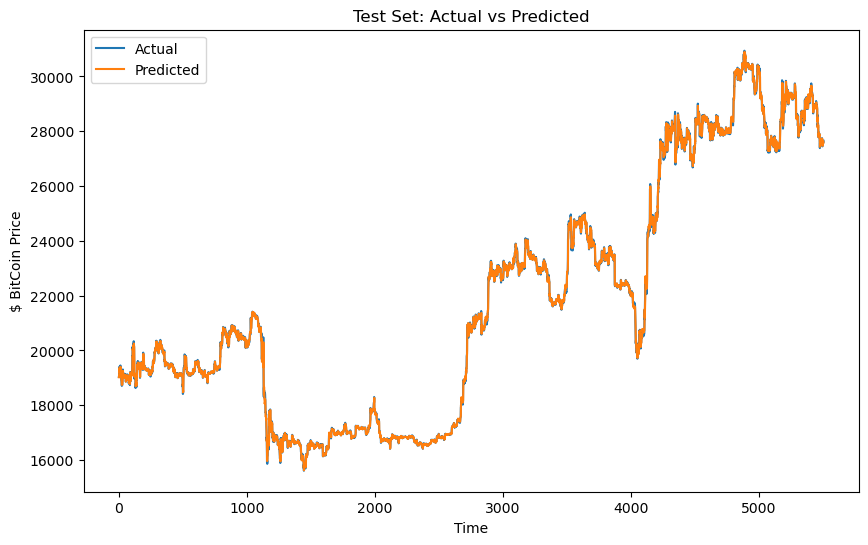

In [91]:

# Plotting
plt.figure(figsize=(10,6))
plt.plot(y_test_d[1:].index, y_test[1:], label='Actual')
plt.plot(y_test_d[1:].index, ridge3_test_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()

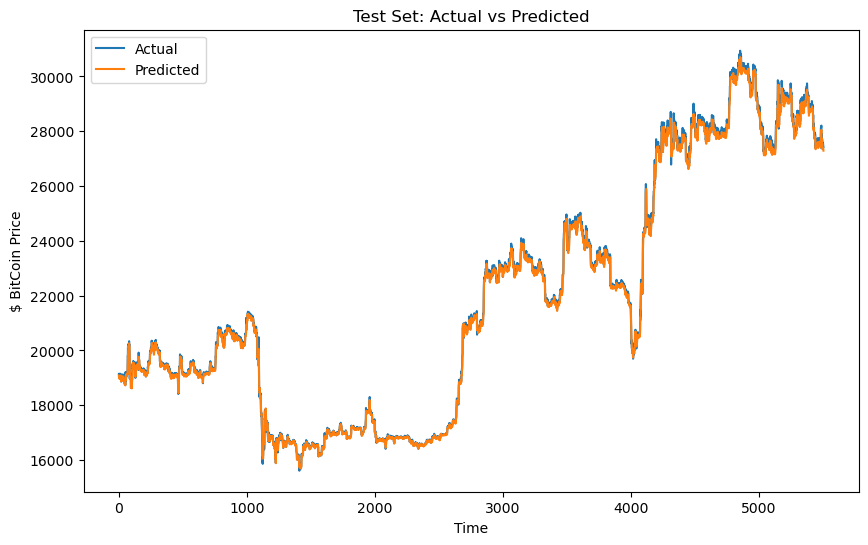

In [93]:
plt.figure(figsize=(10,6))
plt.plot(y2_test_d[sequence_length -1:].index, y2_test_reshaped, label='Actual')
plt.plot(y2_test_d[sequence_length -1:].index, lstm2_test_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('Test Set: Actual vs Predicted')
plt.show()

# Conclusion

We can see from the graphs that the LSTM's outputs experiences more deviation from the actual price in the later stage of the prediction. Therefore, the LSTM model is more likely to degrade over-time and is more over-fitted to the training and validation set. Therefore, among all the models fitted in this project, ridge is the ideal model to be used for hourly-frequency trading.

# Bonus

## Test performances of other models

The other models performed positively because the overall price of bitcoin increased drastically during the time of the test data set, enabling any model to earn money despite low R-squared. 

Tests of other models:

In [94]:
rf_test_pred = rf.predict(X_test)
calculate_metrics(rf_test_pred, y_test)

The MAE is 764.0418794689854.  
The RMSE is 886.8432718232988.  
The r_squared is 0.9594227694676492.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [95]:
rf2_test_pred = rf2.predict(X_test[:,accessible])
calculate_metrics(rf2_test_pred, y_test)

The MAE is 742.5007371072933.  
The RMSE is 870.4954825548133.  
The r_squared is 0.9609049570438534.


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.0s finished


In [96]:
xgb_test_pred = xgb.predict(X_test)
calculate_metrics(xgb_test_pred, y_test)

The MAE is 620.8531316666765.  
The RMSE is 718.052381416528.  
The r_squared is 0.9733988198078698.


In [97]:
xgb2_test_pred = xgb2.predict(X_test[:,accessible])
calculate_metrics(xgb2_test_pred, y_test)

The MAE is 596.7354929344945.  
The RMSE is 694.8106987194667.  
The r_squared is 0.9750929871107112.


In [98]:
mlp_test_pred = mlp.predict(X_test)
calculate_metrics(mlp_test_pred, y_test)

The MAE is 2192.1267640257847.  
The RMSE is 2228.878663909752.  
The r_squared is 0.7436923875390975.


In [99]:
mlp2_test_pred = mlp2.predict(X_test[1:,accessible])
mlp2_test_pred = mlp2_test_pred + y_test[:len(y_test)-1]
calculate_metrics(mlp2_test_pred, y_test[1:])

The MAE is 65.74009944340975.  
The RMSE is 113.80095637517022.  
The r_squared is 0.9993319120414291.


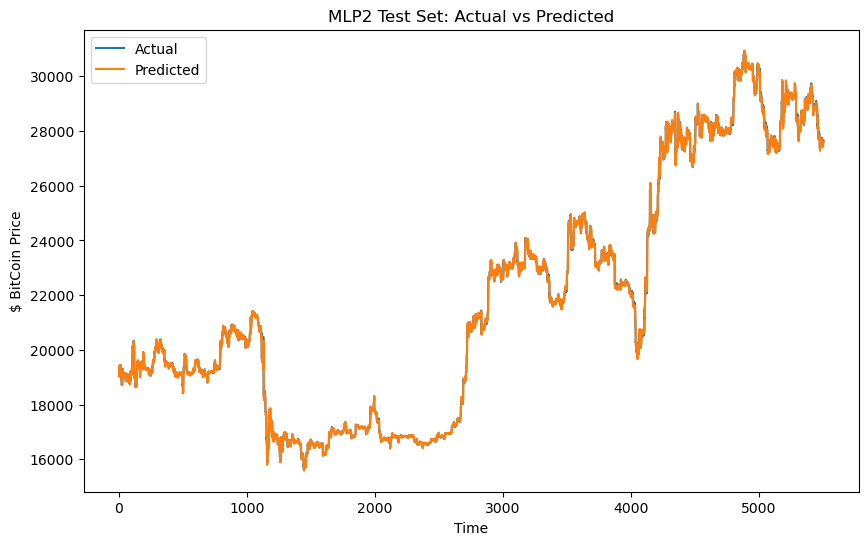

In [100]:
plt.figure(figsize=(10,6))
plt.plot(y_test_d[1:].index, y_test[1:], label='Actual')
plt.plot(y_test_d[1:].index, mlp2_test_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('MLP2 Test Set: Actual vs Predicted')
plt.show()

In [101]:
test_outputs = (rf_test_pred, rf2_test_pred, xgb_test_pred, xgb2_test_pred , mlp_test_pred, mlp2_test_pred)
column_names =['rf_test_pred', 'rf2_test_pred', 'xgb_test_pred,','xgb2_test_pred', 'mlp_test_pred', 'mlp2_test_pred']

min_length = min([len(output) for output in test_outputs])

test_df = pd.DataFrame({'real_price': y_test})

starting_position = len(test_df) - min_length

test_df = test_df.iloc[starting_position:,]

for output, column_name in zip(test_outputs,column_names):
    starting_position = len(output) - min_length
    print(column_name)
    test_df[column_name] = output[starting_position:] 
test_df['average_predicted_price'] = test_df.iloc[:,1:].mean(axis=1)
test_df = test_df.reset_index(drop = True)

rf_test_pred
rf2_test_pred
xgb_test_pred,
xgb2_test_pred
mlp_test_pred
mlp2_test_pred


In [102]:
back_test(test_df)

The asset growth rate would be 270242.76% if trades were conducted upon real_price in a 229.33days period
The asset growth rate would be 28.48% if trades were conducted upon rf_test_pred in a 229.33days period
The asset growth rate would be 69.98% if trades were conducted upon rf2_test_pred in a 229.33days period
The asset growth rate would be 91.65% if trades were conducted upon xgb_test_pred, in a 229.33days period
The asset growth rate would be 87.66% if trades were conducted upon xgb2_test_pred in a 229.33days period
The asset growth rate would be 45.26% if trades were conducted upon mlp_test_pred in a 229.33days period
The asset growth rate would be 712.76% if trades were conducted upon mlp2_test_pred in a 229.33days period
The asset growth rate would be 45.26% if trades were conducted upon average_predicted_price in a 229.33days period


You might be suprised to why MLP had a 45.26% return rate despite only giving an r-squared of 0.66. It is because the model consistently overestimates the price of bitcoin, causing the buyers to hold on to the bitcoins while bitcoin price increased from 2022-10 to 2023-05. The graph below should explain

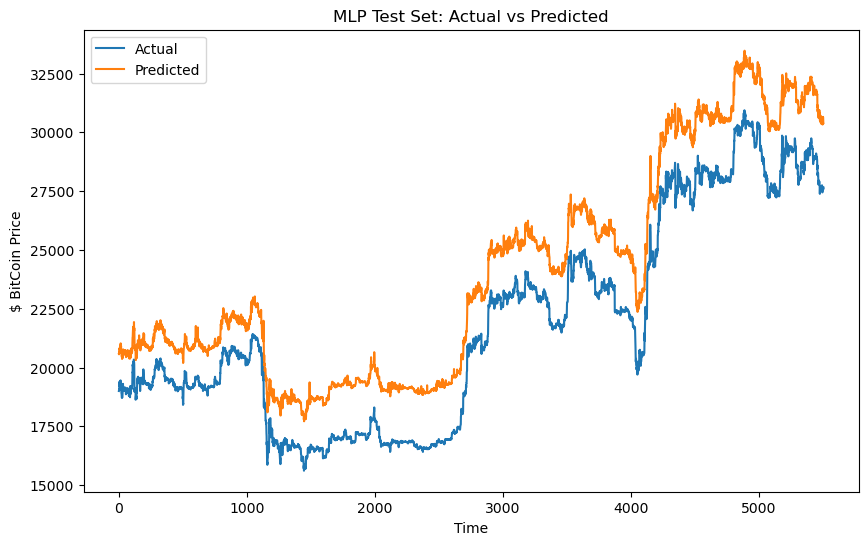

In [103]:
plt.figure(figsize=(10,6))
plt.plot(y_test_d.index, y_test, label='Actual')
plt.plot(y_test_d.index, mlp_test_pred, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('$ BitCoin Price')
plt.title('MLP Test Set: Actual vs Predicted')
plt.show()